<a href="https://colab.research.google.com/github/HeeminYang/Study_Hondson_ml3/blob/main/part12-13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**12장 – 텐서플로를 사용한 사용자 정의 모델과 훈련**

_이 노트북은 12장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩 명령입니다.
    %tensorflow_version 2.x
except Exception:
    pass

# 이 노트북은 텐서플로 ≥2.4이 필요합니다
# 2.x 버전은 대부분 동일한 결과를 만들지만 몇 가지 버그가 있습니다.
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# PART 2 START

## 텐서플로 함수

텐서플로우 2에서 그래프 연산 과정에 대해서.  
함수 cube()를 먼저 정의합니다.

In [2]:
def cube(x):
    return x ** 3

이 cube()함수를 파이썬 int, float으로 호출할 수 있고 tensor로도 호출할 수 있습니다.

In [3]:
cube(2)

8

In [4]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

이번엔 cube()함수를 `tf.function()`을 통해 텐서플로우 함수로 변환해봅시다.

In [5]:
tf_cube = tf.function(cube)
tf_cube

tf_cube도 동일하게 사용할 수 있고 같은 값을 반환합니다. (하지만 구조는 tensor로)

In [6]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [7]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### TF 함수와 콘크리트 함수

get_concrete_funtion은 텐서플로우 계산 그래프에서 만들어지며, 특정 입력값을 갖는 그래프의 특정 부분을 실행할 수 있습니다. 이렇게 하면 그래프 전체를 구축하고 계산을 수행하는 비용을 들이지 않으면서도 그래프를 실행할 수 있습니다.

내부적으로는 파이썬 함수에서 수행되는 계산을 분석하고 동일한 작업을 수행하는 계산 그래프를 생성합니다. 다만, 같은 크기의 자료형을 가지는 입력값이 들어오면 그래프를 재활용해주고 새로운 유형이면 새롭게 그래프를 생성합니다.


In [8]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

tf_cube = <tensorflow.python.eager.def_function.**Function** at 0x7fb1f517e4f0>

concrete_function = <tensorflow.python.framework.func_graph.**FuncGraph** at 0x7fb1803694c0>


In [9]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [10]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### 함수 정의와 그래프

In [11]:
concrete_function.graph

In [12]:
ops = concrete_function.graph.get_operations()
ops # pow = power 거듭제곱

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [13]:
ops[2]

<tf.Operation 'pow' type=Pow>

In [14]:
pow_op = ops[2]
list(pow_op.inputs) # ops[2] 이전 오퍼레이션을 인풋으로

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [15]:
pow_op.outputs # pow가 아웃풋으로

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [16]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [17]:
concrete_function.graph.get_operation_by_name('pow/y')

<tf.Operation 'pow/y' type=Const>

In [18]:
concrete_function.graph.get_operation_by_name('Identity') # input과 똑같은 output을 내뱉는 함수

<tf.Operation 'Identity' type=Identity>

In [19]:
concrete_function.graph.get_tensor_by_name('x:0')

<tf.Tensor 'x:0' shape=() dtype=float32>

In [20]:
concrete_function.graph.get_tensor_by_name('pow/y:0')

<tf.Tensor 'pow/y:0' shape=() dtype=float32>

In [21]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [22]:
concrete_function.function_def.signature

name: "__inference_cube_16"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### TF 함수가 계산 그래프를 추출하기 위해 파이썬 함수를 트레이싱하는 방법

다른방법으로는 tf.function 데코레이터가 더 널리 사용됩니다.

데코레이터 @tf.function를 쓰고 밑에다가 사용하고 싶은 함수를 작성하면 알아서 텐서플로우 함수로 바꿔줍니다.

In [23]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [24]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [25]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

원본 파이썬 함수는필요할때 python_function 속성으로 참조할 수 있습니다.

In [26]:
tf_cube.python_function(2)

print: 2


8

텐서플로우 함수는 호출에 사용되는 입력 크기와 데이터 타입에 맞춰 매번 새로운 그래프를 생성합니다.    
예로, 
1. tf_cube()에 tf.constant(10)를 넣어 호출하면 [ ]크기의 int32텐서에 맞는 그래프가 생성됩니다. 
2. tf_cube()에 tf.constant(20)를 넣어 호출하면 동일한 그래프를 재사용합니다. 
3. tf_cube()에 tf.constant([10, 20])를 넣어 호출하면 [2]크기의 int32텐서에 맞는 그래프가 생성됩니다. 
4. 파이썬 값을 텐서플로우 함수에 전달하면 값 마다 새로운 그래프를 생성합니다.   
  1. 예) tf_cube(10), tf_cube(20)은 두 개의 그래프를 생성합니다.

In [27]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # New shape: trace!

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)
print: Tensor("x:0", shape=(3, 2), dtype=float32)


텐서플로우는 사용하지 않는 노드를 제거하고 표현을 단순화하는 등의 방식으로 계산 그래프를 최적화합니다(1+2를 3으로 대체하는 식). 최적화돤 그래프로 텐서플로우 함수를 적절한 순서에 맞춰(가능하면 병렬로) 그래프 내의 연산을 효율적으로 실행합니다.
> 따라서 일반적으로 텐서플로우 함수가 기본 파이썬 함수보다 빠르게 실행됩니다.   

특히 복잡한 연산을 할 때 유용합니다.

특정 입력 시그니처를 지정하는 것도 가능합니다:

In [28]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("트레이싱", images)
    return images[:, ::2, ::2] # 행과 열의 절반을 버립니다

In [29]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [30]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # 함수 트레이싱
preprocessed_images = shrink(img_batch_2) # 동일한 콘크리트 함수 재사용

트레이싱 Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [31]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # 다른 타입이나 크기 거부
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


사용자 정의 손실, 지표, 레이어 또는 다른 어떤 사용자 정의함수를 작성하고 이를 케라스 모델에 사용할 때 케라스는 이 함수를 자동으로 텐서플로우 함수로 변환합니다. tf.function()을 사용할 필요가 없습니다.

### 오토그래프를 사용해 제어 흐름 나타내기

파이썬 코드를 통해 텐서플로우 함수 그래프를 그리는 과정    

오토그래프: 파이썬 함수의 **소스코드를** 분석하여 for, while, if, break, continue, return와 같은 제어문을 찾는 과정입니다.    
텐서플로우가 소스코드를 분석하는 이유는 제어문을 찾는 기능이 파이썬에 없기 때문입니다.   
예)   
for문은 tf.while_loop()로 바꾸고 if문은 tf.cond()로 바꿉니다. 

`sum_squares()`

In [32]:
@tf.function
def sum_squares(n):
  s = 0
  for i in tf.range(n + 1):
    s += i ** 2
  return s

오토그래프는 sum_sqaures() 파이썬 함수의 소스코드를 분석하고 tf__sum_sqaures() 함수를 생성합니다. 이 함수에서 for문은 (원래 반복문 for 안의 코드를 포함한) loop_body() 함수로 바뀌었습니다. 그다음 for_stmt()함수를 호출합니다. 이 함수는 계산 그래프 안에 적절한 tf.while_loop() 연산을 만들 것입니다.

그 다음 텐서플로우가 이 업그레이드된 함수를 호출합니다. 하지만 매개변수 값을 전달하는 대신 심볼릭 텐서(symbolic tensor)를 전달합니다. 이 텐서는 실제 값이 없고 이름, 데이터 타입, 크기만 가집니다.

예를 들어 sum_squares(tf.constant(10))를 호출하면 tf__sum_squares() 함수는 크기가 [ ]이고 int32 타입의 심볼릭 텐서를 사용해 호출됩니다. 이 함수는 그래프 모드(graph mode)로 실행될 것입니다. 이는 각 텐서플로우 연산이 해당 연산을 나타내고 텐서를 출력하기 위해 그래프에 노드를 추가한다는 의미입니다(즉시 실행모드(eager mode)로 부르는 일반적인 모드와 반대입니다). 텐서플로우 연산은 어떤 계산도 수행하지 않습니다.

tf__sum_squares()함수가 심볼릭 텐서를 매개변수로 하여 호출됩니다(이경우에는 크기가 [ ] 이고 int32 타입의 텐서). 최종 그래프는 트레이싱 과정을 통해 생성됩니다. 노드는 연산을 나타내고 화살표는 텐서를 나타냅니다(이 그림에서 생성된 함수와 그래프는 모두 단순화한 것입니다).

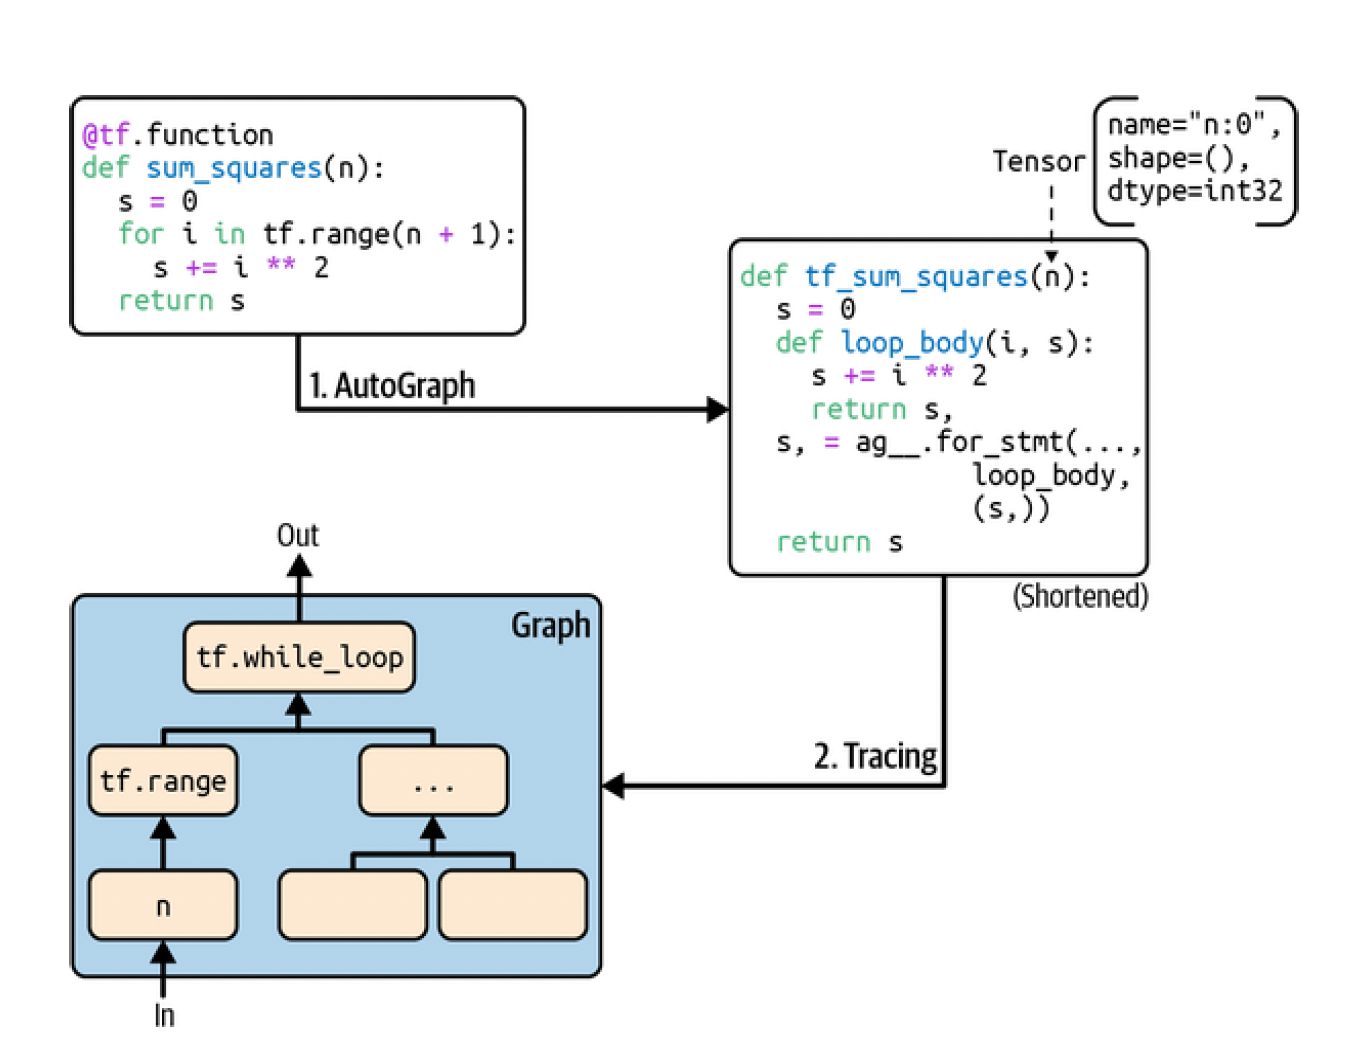

`range()`를  사용한 정적인 `for` 반복:

텐서플로우는 텐서나 데이터셋을 순회하는 for문만 감지합니다. 따라서 for i in range(x) 대신 for i in tf.range(x)를 사용해야합니다. 그렇지 않으면 이 반복문이 그래프에 표현되지 못할 것입니다. 대신 트레이싱 단계에서 실행됩니다(일부러 이런 for문을 사용해 그래프를 만들 수 있습니다. 예를 들면 신경망의 층을 반복문으로 만듭니다).

In [33]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [34]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [35]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

`tf.while_loop()`를 사용한 동적인 반복:

In [36]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [37]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [38]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

(오토그래프에 의한) `tf.range()`를 사용한 동적인 `for` 반복:

In [39]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [40]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

## tf.keras와 TF 함수를 함께 사용하거나 사용하지 않기

기본적으로 tf.keras는 자동으로 사용자 정의 코드를 TF 함수로 변환하기 때문에 `tf.function()`을 사용할 필요가 없습니다:

In [52]:
# 사용자 손실 함수
def my_mse(y_true, y_pred):
    print("my_mse() 손실 트레이싱")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [53]:
# 사용자 지표 함수
def my_mae(y_true, y_pred):
    print("my_mae() 지표 트레이싱")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [54]:
# 사용자 정의 층
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("MyDense.call() 트레이싱")
        return self.activation(X @ self.kernel + self.biases)

In [55]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
# 사용자 정의 모델
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("MyModel.call() 트레이싱")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [57]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [59]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [60]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
352/363 [============================>.] - ETA: 0s - loss: 1.3487 - my_mae: 0.7988MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
363/363 [==============================] - 6s 4ms/step - loss: 1.3255 - my_mae: 0.7900 - val_loss: 0.5569 - val_my_mae: 0.4819
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.4164 - my_mae: 0.4639


[0.4163525104522705, 0.4639028012752533]

`dynamic=True`로 모델을 만들어 이 기능을 끌 수 있습니다(또는 모델의 생성자에서 `super().__init__(dynamic=True, **kwargs)`를 호출합니다):

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [62]:
model = MyModel(dynamic=True)

In [63]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

사용자 정의 코드는 반복마다 호출됩니다. 너무 많이 출력되는 것을 피하기 위해 작은 데이터셋으로 훈련, 검증, 평가해 보겠습니다:

In [64]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱


[5.507259368896484, 2.0566811561584473]

또는 모델을 컴파일할 때 `run_eagerly=True`를 지정합니다:

In [65]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [66]:
model = MyModel()

In [67]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [68]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱
MyModel.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
MyDense.call() 트레이싱
my_mse() 손실 트레이싱
my_mae() 지표 트레이싱


[5.507259368896484, 2.0566811561584473]

# 연습문제

## 1. to 11.

1. 텐서플로우를 한 줄 요약하면? 텐서플로우의 주요 특징은 뭘까요? 다른 유명한 라이브러리 이름을 말해보세요.   
  *   텐서플로우는 대규모 머신러닝을 위해 튜닝된 오픈소스 라이브러리입니다.
  *   특징: GPU 지원, 분산 컴퓨팅, 계산 그래프 분석, 최적화 기능 제공
  *   다른 딥러닝 라이브러리: 파이토치, MXNet, 마이크로소프트 코그니티브 툴킷, 시애노, 카페2, 체이너
2. 텐서플로우가 넘파이를 대체하는 건가요? 둘의 차이를 말해보세요.
  *   대체할 수 없다.
  1. 모든 함수 이름이 같지 않습니다.
  * `tf.reduce_sum()` $\neq$ `np.sum()`
  2. 일부 함수는 작동 방식이 완전히 같지 않습니다.
    * `tf.transpose()`= 텐서의 전치 복사본 
    * 넘파이의 T 메서드 = 전치된 view(복사 x)
  3. 넘파이 배열은 변경 가능하지만 텐서플로우의 텐서는 만든  후 변경하지 못합니다.
    * 변경 가능한 객체가 필요하면 `tf.variable`을 사용할 수 있습니다
3. `tf.range(10)`와 `tf.constant(np.range(10)`는 같은 결과를 낼까요?
  * 모두 0에서 9까지 정수를 담은 1차원 텐서를 반환합니다. 
    * 하지만 전자는 32비트 정수를 사용하고, 후자는 64비트 정수를 사용합니다. 
    * 실제로 텐서플로우는 32비트가 기본이지만 넘파이는 64비트가 기본입니다.
4. 일반 tensor 외에 다른 데이터 구조 6개를 말해보세요. 
  1. 희소 텐서(sparse tensors)
  2. 텐서 배열(tensor arrays)
  3. 래그드 텐서(ragged tensors)
  4. 큐(queues)
  5. 문자열 텐서(string tensors)
  6. 집합(sets) 
5. `tf.keras.losses.Loss`를 사용하면 사용자 정의 손실함수를 만들 수 있습니다. 언제 만들까요?
 * 사용자 정의 손실함수가 일부 매개변수를 지원해야할 때 (일반적으론 일반 파이썬 함수로 구현)
    * `keras.losses.Loss` 클래스를 상속하고 `__init__()`와 `call()` 메서드를 구현해야 합니다.
    * 손실 함수의 매개변수를 모델과 함께 저장하려면 `get_config()` 메서드도 구현해야 합니다.
6. 비슷하게, 사용자 정의 메트릭스를 만들땐 `tf.keras.metrics.Metric`를 사용합니다. 사용하게 되는 경우를 말해보세요.
  * 사용자 정의 지표가 일부 매개변수를 지원해야할 때 (대부분의 지표는 일반 파이썬 함수로 정의)
  * 한 에포크 전체에 대해 지표를 계산하는 것과 에포크 안의 모든 배치에 대해 평균 지표를 계산하는 것이 동일하지 않을때 (예: 정밀도와 재현율)
      * `keras.metrics.Metric` 클래스를 상속하고 `__init__()`, `update_state()`, `result()` 메서드를 구현하여 에포크 동안에 변화하는 지푯값을 기록 
      * 변수를 0.0으로 초기화 하는 것이 필요하지 않다면 `reset_states()` 메서드도 구현해야 함
      * 모델과 함께 상태를 저장하려면 `get_config()` 메서드도 구현해야 함
7. 사용자 정의 레이어와 사용자 정의 모델을 만드는 경우의 차이점을 말해보세요.
  * 모델의 내부 구성 요소(즉 레이어 또는 재사용 가능한 레이어의 블럭)와 모델 자체(즉 훈련할 대상)로 구분합니다. 
  * 전자는 `keras.layers.Layer` 클래스를 상속하고 후자는 `keras.model.Model`클래스를 상속해야 합니다.
8. 사용자 정의 학습 반복(loops)을 만들어야하는 경우는 언제일까요?
  * 왠만하면 하지마세요.
  * 하지만 일부 경우에는 사용자 정의 반복이 필수적입니다. 예를 들어 와이드 & 딥 논문 처럼 신경망의 일부분에 다른 옵티마이저를 사용하는 경웁니다.
9. 사용자 정의 케라스 구성 요소는 임의의 파이썬 코드를 사용할 수 있나요? 아니면 텐서플로우 함수로 바꿔서 사용해야하나요?
  * 텐서플로우 함수로 바꿀 수 있어야 합니다. 
  * 가능하면 텐서플로우 연산만 사용하고 특정 규칙을 따라야 합니다. 
  * 사용자 정의 구성 요소에 임의의 파이썬 코드를 넣어야 한다면 tf.py_function() 연산으로 감싸거나(그러나 성능이 감소되고 모델의 이식성에 제약이 생깁니다), 
  * 사용자 정의 층이나 모델을 만들 때 dynamic=True로 지정합니다(또는 모델의 compile() 메서드를 호출할 때 run_eagerly=True를 지정해야 합니다).
10. 일반 함수를 TF함수로 변경할 때 지켜야되는 주요 규칙은 뭔가요?
  * 아래 참조
11. dynamic Keras model(sub class로 만드는 구조)를 만들어야 하는 경우는 언제인가요? 어떻게 만들죠? 모델 전체를 dynamic 구조로 만드는 건요?
  * 동적인 케라스 모델을 만들면 디버깅에 유용합니다. 
  * 사용자 정의 구성 요소를 텐서플로우 함수로 컴파일하지 않으므로 코드 디버깅을 위해 어떤 파이썬 디버거를 사용할 수 있습니다. 
  * 외부 라이브러리를 호출하는 것을 포함해 모델(또는 훈련 코드)에 임의의 파이썬 코드를 넣고 싶을 때도 사용합니다.

### 정답 전체

1. TensorFlow는 수치 계산, 특히 대규모 머신러닝에 잘 맞도록 튜닝된 오픈소스 라이브러리입니다. 라이브러리 핵심 부분은 넘파이와 비슷하지만 GPU를 지원합니다. 또한 분산 컴퓨팅, 계산 그래프 분석과 최적화 기능을 제공합니다(이식성이 좋은 그래프 포맷 덕분에 하나의 환경에서 텐서플로우 모델을 훈련하고 다른 환경에서 실행할 수 있습니다). 후진 모드 자동미분 기반의 최적화 API와 `tf.keras`, `tf.dsata`, `tf.image`, `tf.signal` 등과 같은 강력한 API를 제공합니다. 다른 인기있는 딥러닝 라이브러리는 파이토치, MXNet, 마이크로소프트 코그니티브 툴킷, 시애노, 카페2, 체이너가 있습니다.
2. 텐서플로우가 넘파이 기능을 대부분 제공하지만 몇 가지 이유로 대체재가 되지는 못합니다. 
  1. 첫째 모든 함수 이름이 같지 않습니다(예를 들어 `tf.reduce_sum()`과 `np.sum()`이 다릅니다). 
  2. 둘째 일부 함수는 작동 방식이 완전히 같지 않습니다(예를 들어 `tf.transpose()`는 텐서의 전치 복사본을 만들지만 넘파이의 T 메서드는 실제로 어떤 데이터를 복사하는 것이 아니라 전치된 view를 만듭니다). 
  3. 마지막으로 넘파이 배열은 변경 가능하지만 텐서플로우의 텐서는 만든  후 변경하지 못합니다(변경 가능한 객체가 필요하면 `tf.variable`을 사용할 수 있습니다).
3. `tf.range(10)`와 `tf.constant(np.arange(10))`는 모두 0에서 9까지 정수를 담은 1차원 텐서를 반환합니다. 하지만 전자는 32비트 정수를 사용하고, 후자는 64비트 정수를 사용합니다. 실제로 텐서플로우는 32비트가 기본이지만 넘파이는 64비트가 기본입니다.
4. 일반 텐서 이외에도 텐서플로우는 여러가지 다른 데이터 구조를 제공합니다. 희소 텐서, 텐서 배열, 래그드 텐서, 큐, 문자열 텐서, 집합 등입니다. 마지막 두개(문자열, 집합)는 사실 일반 텐서로 표현되지만 텐서플로우가 이를 조작하기 위한 특별한 함수를 (`tf.strings`와 `tf.sets` 안에) 제공합니다.
5. 사용자 정의 손실함수를 정의하려면 일반적으로 일반 파이썬 함수로 구현합니다. 하지만 사용자 정의 손실함수가 일부 매개변수를 (또는 다른 어떤 상태를) 지원해야 한다면 `keras.losses.Loss` 클래스를 상속하고 `__init__()`와 `call()` 메서드를 구현해야 합니다. 손실 함수의 매개변수를 모델과 함께 저장하려면 `get_config()` 메서드도 구현해야 합니다.
6. 사용자 손실 함수와 매우 비슷하게 대부분의 지표는 일반 파이썬 함수로 정의할 수 있습니다. 하지만 사용자 정의 지표가 일부 매개변수를 (또는 다른 어떤 상태를) 지원해야 한다면 `keras.metrics.Metric` 클래스를 상속해야 합니다. 또한 한 에포크 전체에 대해 이 지표를 계산하는 것과 에포크 안의 모든 배치에 대해 평균 지표를 계산하는 것이 동일하지 않으면 (예를 들어 정밀도와 재현율이 그렇습니다) `keras.metrics.Metric` 클래스를 상속하고 `__init__()`, `update_state()`, `result()` 메서드를 구현하여 에포크 동안에 변화하는 지푯값을 기록해야 합니다. 또한 변수를 0.0으로 초기화 하는 것이 필요하지 않다면 `reset_states()` 메서드도 구현해야 합니다. 모델과 함께 상태를 저장하려면 `get_config()` 메서드도 구현해야 합니다.
7. 모델의 내부 구성 요소(즉 레이어 또는 재사용 가능한 레이어의 블럭)와 모델 자체(즉 훈련할 대상)로 구분합니다. 전자는 `keras.layers.Layer` 클래스를 상속하고 후자는 `keras.model.Model`클래스를 상속해야 합니다.
8. 사용자 훈련 반복을 작성하는 것은 매우 고급 기능이기 때문에 정말 필요할 때만 사용해야 합니다. 케라스는 사용자 정의 훈련 반복을 작성하지 않고 훈련을 커스터마이징할 수 있는 여러 도구를 제공합니다. 콜백, 사용자 정의 규제, 사용자 정의 제한, 사용자 정의 손실 등입니다. 가능하다면 사용자 정의 훈련 반복 대신 이런 도구를 사용해야 합니다. 사용자 정의 훈련 반복을 만들면 올가 발생하기 쉽고 작성한 코드를 재사용하기 어렵습니다. 하지만 일부 경우에는 사용자 정의 반복이 필수적입니다. 예를 들어 와이드 & 딥 논문 처럼 신경망의 일부분에 다른 옵티마이저를 사용하는 경웁니다. 사용자 정의 훈련 반복은 디버깅이나 훈련이 어떻게 작동하는지 이해하고 싶을 때 사용할 수도 있습니다.
9. 사용자 정의 케라스 구성 요소는 텐서플로우 함수로 바꿀 수 있어야 합니다. 즉 가능하면 텐서플로우 연산만 사용하고 특정 규칙을 따라야 합니다. 사용자 정의 구성 요소에 임의의 파이썬 코드를 넣어야 한다면 tf.py_function() 연산으로 감싸거사(그러나 성능이 감소되고 모델의 이식성에 제약이 생깁니다), 사용자 정의 층이나 모델을 만들 때 dynamic=True로 지정합니다(또는 모델의 compile() 메서드를 호출할 때 run_eagerly=True를 지정해야 합니다).
10. 
11. 동적인 케라스 모델을 만들면 디버깅에 유용합니다. 사용자 정의 구성 요소를 텐서플로우 함수로 컴파일하지 않으므로 코드 디버깅을 위해 어떤 파이썬 디버거를 사용할 수 있습니다. 외부 라이브러리를 호출하는 것을 포함해 모델(또는 훈련 코드)에 임의의 파이썬 코드를 넣고 싶을 때도 사용합니다. 동적인 모델을 만들려면 모델을 생성할 때 dynamic=True로 지정해야 합니다. 또는 모델의 compile() 메서드를 호출할 때 run_eagerly=True를 지정합니다. 모델을 동적으로 만들면 케라스가 텐서플로우의 그래프 장점을 활용하지 못합니다. 따라서 훈련과 추론 속도가 느려지고 계산 그래프로 내보낼 수 없어 모델의 이석성에 제약이 생깁니다.

10. 텐서플로우 함수 사용 방법
  1. <텐서플로우 안의 함수를 사용> 넘파이나 표준 라이브러리를 포함해서 다른 라이브러리를 호출하면 트레이싱 과정에서 실행될 것입니다. 이 호출은 그래프에 포함되지 않습니다. 실제 텐서플로우 그래프는 텐서플로우 구성 요소(텐서, 연산, 변수, 데이터셋 등)만 포함할 수 있습니다. 따라서 (트레이싱 과정에서 코드가 실행되는 것을 원하지 않는다면) np.sum() 대신에 tf.reduce_sum()을, sorted() 내장 함수 대신에 tf.sort()와 같이 사용하세요. 이것이 미치는 영향이 몇가지 더 있습니다.
  2. 다른 파이썬 함수나 텐서플로우 함수를 호출할 수 있습니다. 하지만 텐서플로우가 계산 그래프에 있는 이 함수들의 연산을 감지하므로 동일한 규칙을 따릅니다. 이러한 함수들은 @tf.function 데코레이터를 적용할 필요가 없습니다. 
    * 그래프 모드로 계산할 첫 번째 함수에만 적용하면 됩니다. 함수 안에서 일어나는 (외부 라이브러리가 아닌) 다른 함수 호출은 자동으로 그래프 모드가 적용합니다.사용자 정의 층을 만든다면 전형적으로 __call__()메서드에 데코레이터를 적용합니다.
  3. 함수에서 텐서플로우 변수를 만든다면 처음 호출될 때만 수행되어야 합니다. 아니면 예외가 발생합니다. 일반적으로 텐서플로우 함수 밖에서 변수를 생성하는 것이 좋습니다(예를 들면 사용자 정의 층의 build() 메서드). 변수에 새로운 값을 할당하려면 = 연산자 대신에 assign() 메서드를 사용하세요.
  4. 파이썬 함수의 소스 코드는 텐서플로우에서 사용 가능해야 합니다. 만약 소스 코드를 사용할 수 없다면 (예를 들어, 소스 코드에 접근할 수 없는 파이썬 셸에서 함수를 정의하거나 컴파일된 *.pyc 파이썬 파일을 상용 환경에 배포한다면) 그래프 생성 과정이 실패하거나 일부 기능을 사용할 수 없을 것입니다. 
  5. 텐서플로우는 텐서나 데이터셋을 순회하는 for문만 감지합니다. 따라서 for i in range(x) 대신 for i in tf.range(x)를 사용해야합니다. 그렇지 않으면 이 반복문이 그래프에 표현되지 못할 것입니다. 대신 트레이싱 단계에서 실행됩니다(일부러 이런 for문을 사용해 그래프를 만들 수 있습니다. 예를 들면 신경망의 층을 반복문으로 만듭니다).
  6. 성능면에서는 반복문보다 가능한 한 벡터화된 구현을 사용하는 것이 좋습니다.


## 12. _층 정규화_ 를 수행하는 사용자 정의 층을 구현하세요.

_15장에서 순환 신경망을 사용할 때 이런 종류의 층을 사용합니다._

### a.
_문제: `build()` 메서드에서 두 개의 훈련 가능한 가중치 *α*와 *β*를 정의합니다. 두 가중치 모두 크기가 `input_shape[-1:]`이고 데이터 타입은 `tf.float32`입니다. *α*는 1로 초기화되고 *β*는 0으로 초기화되어야 합니다._

솔루션: 아래 참조.

### b.
_문제: `call()` 메서드는 샘플의 특성마다 평균 μ와 표준편차 σ를 계산해야 합니다. 이를 위해 전체 샘플의 평균 μ와 분산 σ<sup>2</sup>을 반환하는 `tf.nn.moments(inputs, axes=-1, keepdims=True)`을 사용할 수 있습니다(분산의 제곱근으로 표준편차를 계산합니다). 그다음 *α*⊗(*X* - μ)/(σ + ε) + *β*를 계산하여 반환합니다. 여기에서 ⊗는 원소별
곱셈(`*`)을 나타냅니다. ε은 안전을 위한 항입니다(0으로 나누어지는 것을 막기 위한 작은 상수. 예를 들면 0.001)._

In [ ]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # 반드시 끝에 와야 합니다

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

_ε_ 하이퍼파라미터(`eps`)는 필수가 아닙니다. 또한 `tf.sqrt(variance) + self.eps` 보다 `tf.sqrt(variance + self.eps)`를 계산하는 것이 좋습니다. sqrt(z)의 도함수는 z=0에서 정의되지 않기 때문에 분산 벡터의 한 원소가 0에 가까우면 훈련이 이리저리 널뜁니다. 제곱근 안에 _ε_를 넣으면 이런 현상을 방지할 수 있습니다.

### c.
_문제: 사용자 정의 층이 `keras.layers.LayerNormalization` 층과 동일한(또는 거의 동일한) 출력을 만드는지 확인하세요._

각 클래스의 객체를 만들고 데이터(예를 들면, 훈련 세트)를 적용해 보죠. 차이는 무시할 수 있는 수준입니다.

In [ ]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.80914e-08>

네 충분히 가깝네요. 조금 더 확실하게 알파와 베타를 완전히 랜덤하게 지정하고 다시 비교해 보죠:

In [ ]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.695759e-08>

여전히 무시할 수 있는 수준입니다! 사용자 정의 층이 잘 동작합니다.

## 13. 사용자 정의 훈련 반복을 사용해 패션 MNIST 데이터셋으로 모델을 훈련해보세요.

_패션 MNIST 데이터셋은 10장에서 소개했습니다._

### a.
_문제: 에포크, 반복, 평균 훈련 손실, (반복마다 업데이트되는) 에포크의 평균 정확도는 물론 에포크 끝에서 검증 손실과 정확도를 출력하세요._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

### b.
_문제: 상위 층과 하위 층에 학습률이 다른 옵티마이저를 따로 사용해보세요._

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

# Setup

This project requires Python 3.7 or above:

In [69]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [70]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [71]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

# 13장 – 텐서플로에서 데이터 적재와 전처리하기

# The tf.data API

데이터셋이란? 연속된 데이터 샘플을 말합니다.
일반적으로 디스크에서 데이터를 점진적으로 읽는 데이터셋을 사용합니다.

`tf.data.Dataset.from_tensor_slices()`를 사용해 메모리에서 전체 데이터셋을 생성해보겠습니다.

In [72]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

`from_tensor_slices()` 함수는 텐서를 입력받아 텐서의 원소가 아이템으로 표현되는 `tf.data.Dataset`을 만듭니다.    
위의 `tf.data.Dataset.from_tensor_slices(X)`와 아래 `tf.data.Dataset.range(10)`가 만든 데이터셋은 동일합니다.

In [77]:
dataset = tf.data.Dataset.range(10)

- 데이터셋의 아이템을 순회했을 경우:

In [78]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [75]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## 연쇄 변환(Chaining Transformations)
데이터셋을 준비 했으면 변환 메서드를 호출해서 변환을 수행합니다.   
각 메서드는 새로운 데이터셋을 반환하므로 다음과 같이 변환 메서드를 연결할 수 있습니다.

In [80]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


Repeat: 호출 반복    
Batch: n개씩 그룹으로 묶음
- 묶고 남은 데이터도 하나로 생각(예: 위의 2개), drop_remainder=True를 사용하면 남은 데이터를 drop함

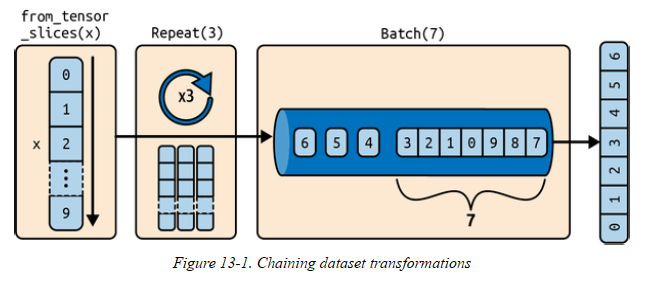

`map()` 메서드를 사용해서 아이템을 변환 할 수도 있습니다.    
아래에서는 2를 곱하여 새로운 데이터셋을 만듭니다.

In [81]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch

In [83]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


1. 데이터에 원하는 모든 전처리 작업을 적용할 수 있습니다.    
2. 이따금 이미지 크기 변환이나 회전 같은 복잡한 계산을 포함하기 때문에 여러 스레드로 나누어 속도를 높이는 것이 좋습니다.    
3. `num_parallel_calls` 매개변수를 지정하면 간단합니다.    
4. `map()` 메서드에 전달하는 함수는 텐서플로우 함수로 변환 가능해야 합니다.

`filter()` 메서드를 통해 데이터셋을 필터링하는 것도 가능합니다.


> 배치 안의 총 합이 50이상만 가진 데이터셋을 만든다.



In [85]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)


`take()`메서드를 사용하면 아이템 몇 개만 불러와서 확인할 수 있습니다.

In [86]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)


## Shuffling the Data

`shuffle()`메서드를 사용하여 샘플을 섞습니다.     
`shuffle()`:
1. 원본 데이터 셋의 처음 아이템을 `buffer_size` 개수만큼 추출하여 버퍼에 채웁니다.
2. 새로운 아이템이 요청되면 버퍼에서 랜덤하게 하나를 꺼내 반환합니다.
3. 원본 데이터셋에서 새로운 아이템을 추출하여 비워진 버퍼를 채웁니다.
4. 원본 데이터셋의 모든 아이템이 사용될 때까지 반복됩니다.
5. 버퍼가 비워질 때까지 계속하여 랜덤하게 아이템을 반환합니다.

셔플링되는 순서를 동일하게 만들려면 랜덤 시드를 부여하면 됩니다.    
> 정수 0에서 9까지 세번 반복되는 데이터셋을 만들고 버퍼 크기5와 시드42를 사용하려 셔플링하고 배치 크기 7로 나누어 출력합니다.

In [87]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([3 0 1 6 2 5 7], shape=(7,), dtype=int64)
tf.Tensor([8 4 1 9 4 2 3], shape=(7,), dtype=int64)
tf.Tensor([7 5 0 8 9 6], shape=(6,), dtype=int64)


### 여러 파일에서 한 줄씩 번갈아 읽기(Interleaving lines from multiple files)
대규모 데이터셋은 버퍼가 데이터셋에 비해 작기 때문에 간단한 셔플링 버퍼 방식으로는 충분하지 않습니다. 이를 해결하는 방법은 원본 데이터 자체를 섞는 것입니다.

샘플을 더 섞기 위해 많이 사용하는 방법 
1. 원본 데이터를 여러 파일로 나눈 다음 훈련하는 동안 무작위로 읽은 것입니다. 
2. 하지만 동일한 파일에 있는 샘플은 여전히 함께 처리됩니다. 이를 피하기 위해 파일 여러 개를 무작위로 선택하고 파일에서 동시에 읽은 레코드를 돌아가면서 반환할 수 있습니다. 
3. 그다음 `shuffle()` 메서드를 사용해 그 위에 셔플링 버퍼를 추가할 수 있습니다.

캘리포니아 주택 데이터셋을 로드하고 준비해 보죠. 먼저 로드한 다음 훈련 세트, 검증 세트, 테스트 세트로 나눕니다.:

In [88]:
# extra code – fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

메모리에 맞지 않는 매우 큰 데이터셋인 경우 일반적으로 먼저 여러 개의 파일로 나누고 텐서플로에서 이 파일들을 병렬로 읽게합니다. 데모를 위해 주택 데이터셋을 20개의 CSV 파일로 나누어 보죠:

In [89]:
# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

좋습니다. 이 CSV 파일 중 하나에서 몇 줄을 출력해 보죠:

In [90]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [91]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

**입력 파이프라인 만들기(Building an Input Pipeline)**

각 파일에 대한 데이터셋 만들기   
`list_files()` 함수는 파일 경로를 섞은 데이터셋을 반환합니다.

In [92]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [93]:
# extra code – shows that the file paths are shuffled
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Ten

`interleave()` 메서드를 호출하여 한 번에 다섯 개의 파일을 한 줄 씩 번갈아 읽습니다.    
(각 파일의 첫 번째 줄은 열 이름이므로 `skip()` 메서드를 사용해 건너 뜁니다.)

In [94]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

이 단계까지 오면 총 7개의 데이터셋이 있는 것입니다.
1. 파일 경로 데이터셋
2. 인터리브 데이터셋
3. 인터리브 데이터셋에 의해 생성된 5개의 `TextLineDataset`

다섯 개의 `TextLineDataset` 순회 과정
1. 모든 데이터셋이 아이템이 소진될 때까지 한 번에 한 줄씩 읽습니다. 
1. `filepath_dataset`에서 다음 다섯개의 파일 경로를 가지고 옵니다.
2. 동일한 방식으로 한 줄씩 읽습니다.
2. 모든 파일 경로가 소진될 때까지 계속됩니다.

병렬화    
`interleave()`는 병렬화를 기본적으로 사용하지 않음(한 줄씩 읽는)   
병렬로 읽고 싶다면 `num_parallel_calls` 매개변수에 원하는 스레드 개수를 지정합니다.    

In [95]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504', shape=(), dtype=string)
tf.Tensor(b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159', shape=(), dtype=string)
tf.Tensor(b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598', shape=(), dtype=string)
tf.Tensor(b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)


## Preprocessing the Data

In [96]:
# extra code – compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

`tf.io.decode_csv()`: 
1. 두개의 매개변수를 입력으로 받는다   
  1. 파싱할 라인(the line to parse)
  2. csv파일의 각 열에 대한 기본값을 담은 배열(an array containing the default value for each columns in the csv file)
2. 출력:
  1. (열마다 한 개씩) 스칼라 텐서의 리스트를 반환합니다. 
2. `tf.stack()` 모든 텐서를 쌒아 1D 배열로 만들어주는 함수
2. x, y를 만들어줍니다.    

`preprocess()` : 입력 특성에서 평균을 빼고 표준편차로 나누어 스케일을 조정합니다. 그다음 스케일 조정된 특성과 타깃을 담은 튜플을 반환합니다.    
`X_mean`, `X_std`: 특성마다 1개씩 8개의 실수를 가진 1D 텐서   


파싱 (Parsing : 구문분석) 은 하나의 프로그램을 런타임환경 (예를 들면, 브라우저 내 자바스크립트 엔진)이 실제로 행할 수 있는 내부 포맷으로 분석하고 변환하는 것을 의미합니다.

즉, 파싱은 문서의 내용을 *토큰(token)으로 분석하고, 문법적 의미와 구조를 반영한 *파스트리(parse tree)를 생성하는 과정입니다.

In [97]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

함수 테스트

In [98]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

## Putting Everything Together + Prefetching(미리불러오기)

지금까지의 기능을 합쳐 하나의 헬퍼함수로 만들겠습니다.    
이 함수는 csv파일에서 캘리포니아 주택 데이터셋을 효율적으로 적재하고 전처리, 셔플링, 반복, 배치를 적용한 데이터셋을 만들어 반환합니다.

In [99]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

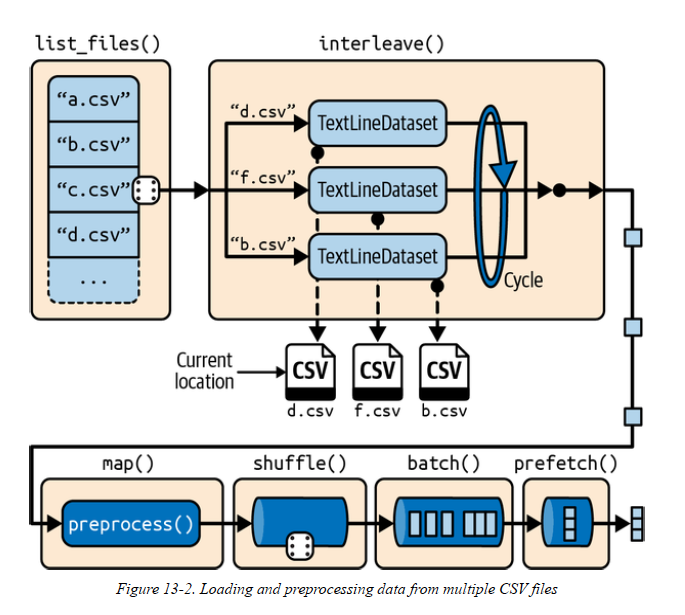

마지막 `prefetch(1)`을 호출하면 데이터셋은 훈련 알고리즘이 한 배치로 작업을 하는 동안 이 데이터셋이 동시에 다음 배치를 준비합니다(예: 디스크에서 데이터를 읽고 전처리를 합니다). 이 기능은 성능을 크게 향상 시킵니다. GPU를 거의 100% 활용할 수 있습니다.

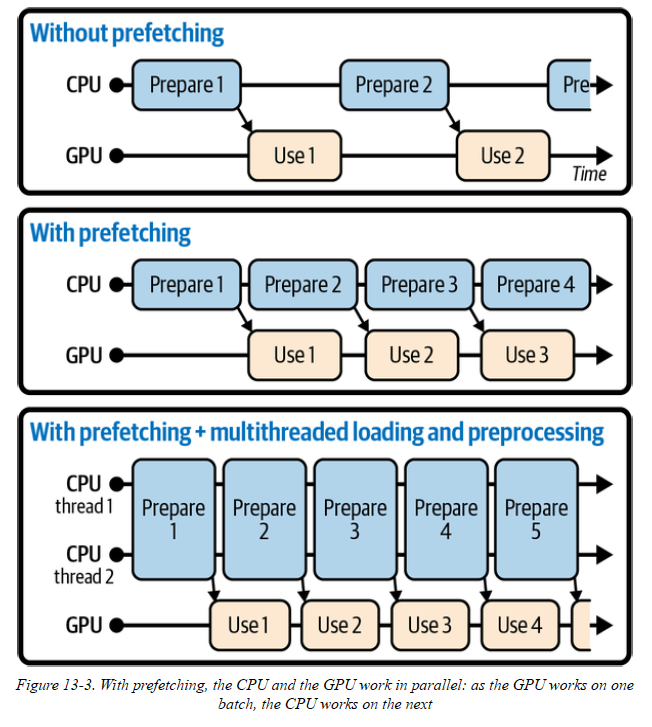

In [100]:
# extra code – show the first couple of batches produced by the dataset

example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.2345318   0.1879177  -0.18384208  0.19340092 -0.4273575   0.49201018
   1.0838584  -1.3871703 ]
 [-1.3836461  -0.7613805  -0.3076956  -0.07978077 -0.05045014  0.32237166
   0.50294524 -0.1027696 ]
 [-0.41767654 -0.91959685 -0.5876468  -0.01253252  2.441884   -0.30059808
  -0.68699217  0.521939  ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.804]
 [0.53 ]
 [1.745]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.58831733  0.02970133 -0.70486885  0.16348003  0.8174406  -0.29916376
  -0.70573175  0.6568782 ]
 [-1.3526396  -1.868895   -0.84703934 -0.0277291   0.58563805 -0.10333684
  -1.3756571   1.2116159 ]
 [-0.16590534  1.8491895  -0.24013318 -0.0694841  -0.141711   -0.41202638
   0.994848   -1.4321475 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.045  ]
 [3.25   ]
 [5.00001]], shape=(3, 1), dtype=float32)



Here is a short description of each method in the `Dataset` class:

In [101]:
# extra code – tf.data.Dataset class의 메소드 리스트
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Create

## tf.keras와 데이터셋 이용하기(Using the Dataset with Keras)

`csv_reader_dataset()`함수로 훈련세트로 사용할 데이터셋을 만들 수 있습니다. `tf.keras`에서 반복을 처리하므로 반복을 지정할 필요가 없습니다.

In [102]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [103]:
# extra code – for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

`fit()`메서드에 훈련, 검증 데이터셋을 전달하면 훈련할 수 있습니다.

In [104]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 0.8518 - val_loss: 54.4304
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5156 - val_loss: 14.4363
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.8050 - val_loss: 6.3684
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4961 - val_loss: 8.7146
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4494 - val_loss: 0.7267


`evaluate()`와 `predict()` 메서드에도 동일하게 전달할 수 있습니다.

In [105]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

3/3 [==============================] - 0s 11ms/step


In [106]:
# extra code – defines the optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # extra code – perform one Gradient Descent step
        #              as explained in Chapter 12
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

훈련반복을 수행하는 텐서플로우 함수를 만들 수도 있습니다.

In [107]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

# TFRecord 포멧(The TFRecord Format)

대용량 데이터를 저장하고 효율적으로 일기 위해 텐서플로우가 선호하는 포맷은 TFRecord입니다. TFRecord는 크기가 다른 연속된 이진 레코드를 저장하는 단순한 이진 포맷입니다.    
레코드 구성
1. 레코드 길이
2. CRC 체크섬(길이가 올바른지 체크)
3. 실제 데이터
4. CRC 체크섬(데이터를 위한)

`tf.io.TFRecordWriter`로 손쉽게 만들 수 있습니다.

순환 중복 검사(巡環重復檢査), CRC(cyclic redundancy check)는 네트워크 등을 통하여 데이터를 전송할 때 전송된 데이터에 오류가 있는지를 확인하기 위한 체크값을 결정하는 방식을 말한다.

In [108]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

`tf.data.TFRecordDataset`로 읽어들입니다.

In [109]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


`TFRecordDataset`는 기본적으로 하나씩 읽습니다. `num_parallel_reads`를 지정하면 여러 파일에서 레코드를 번갈아 읽을 수 있습니다.

In [110]:
# extra code – shows how to read multiple files in parallel and interleave them

filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


## 압축된 TFRedcord(Compressed TFRecord Files)

네트워크를 통해 읽어야 하는 경우, TFRecord 파일을 압축할 필요가 있습니다.

In [111]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

압축된 TFRecord파일을 읽으려면 압축 형식을 지정해야 합니다.

In [112]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")

In [113]:
# extra code – shows that the data is decompressed correctly
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


## 프로토콜 버퍼 개요(A Brief Introduction to Protocol Buffers)

이 절을 위해서는 [프로토콜 버퍼를 설치](https://developers.google.com/protocol-buffers/docs/downloads)해야 합니다. 일반적으로 텐서플로를 사용할 때 프로토콜 버퍼를 설치할 필요는 없습니다. 텐서플로는 tf.train.Example 타입의 프로토콜 버퍼를 만들고 파싱할 수 있는 함수를 제공하며 보통의 경우 충분합니다. 하지만 이 절에서는 자체적인 프로토콜 버퍼를 간단히 만들어 보겠습니다. 따라서 프로토콜 버퍼 컴파일러(protoc)가 필요합니다. 이를 사용해 프로토콜 버퍼 정의를 컴파일하여 코드에서 사용할 수 있는 파이썬 모듈을 만들겠습니다.

각 레코드는 어떤 이진 포맷도 사용할 수 있지만 일반적으로 TFRecord는 직렬화된 프로토콜 버퍼를 담고 있습니다. 프로토콜 버퍼는 2001년 구글이 개발인 이식성과 확장성이 좋고 표율적인 이진 포맷으로 2008년에 오픈 소스로 공개되었습니다. 프로토콜 버퍼는 요즘 널리 사용됩니다. 특히 구글의 원격 프로시저 호출시스템인 gRPC에 사용됩니다. 프로토콜 버퍼는 다음과 같은 간단한 언어를 사용하여 정의합니다.

먼저 간단한 프로토콜 버퍼 정의를 작성해 보죠:

각 Person 객체는
1. string 타입의 name
2. int32 타입의 id
3. string 타입인 email   

필드를 하나 이상 가집니다. 
숫자 1, 2, 3은 필드 식별자로 레코드의 이진 표현에 사용됩니다.   
.proto 파일로 정의를 만든 후 컴파일할 수 있습니다.   

In [114]:
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Writing person.proto


프로토콜 버퍼 컴파일러인 protoc를 사용해 파이썬(또는 다른 언어의) 클래스를 생성합니다. 

이 정의를 컴파일합니다(`--descriptor_set_out`와 `--include_imports` 옵션은 아래 `tf.io.decode_proto()` 예제를 위해서 필요합니다):

In [115]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [116]:
!ls person*

person.desc  person_pb2.py  person.proto


In [117]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # Person 생성
print(person)  # Person 출력

name: "Al"
id: 123
email: "a@b.com"



In [118]:
person.name  # 필드 읽기

'Al'

In [119]:
person.name = "Alice"  # 필드 수정

In [120]:
person.email[0]  # 배열처럼 사용할 수 있는 반복 필드

'a@b.com'

In [121]:
person.email.append("c@d.com")  # 이메일 추가

In [122]:
s = person.SerializeToString()  # 바이트 문자열로 직렬화
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [123]:
person2 = Person()  # 새로운 Person 생성
person2.ParseFromString(s)  # 바이트 문자열 파싱 (27 바이트)

27

In [124]:
person == person2  # 동일

True

#### 사용자 정의 protobuf

드문 경우에 텐서플로에서 (앞서 우리가 만든 것처럼) 사용자 정의 프로토콜 버퍼를 파싱해야 합니다. 이를 위해 `tf.io.decode_proto()` 함수를 사용할 수 있습니다:

In [125]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

더 자세한 내용은 [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) 문서를 참고하세요.

## 텐서플로우 프로토콜 버퍼(TensorFlow Protobufs)

TFRecord 파일에서 사용하는 전형적인 주요 프로토콜 버퍼는 데이터셋에 있는 하나의 샘플을 표현하는 Example 프로토콜 버퍼입니다. 이 프로토콜 버퍼는 이름을 가진 특성의 리스트를 가지고 있습니다. 각 특성은 바이트 스트링의 리스트나 실수의 리스트, 정수의 리스트 중 하나입니다.

다음이 `tf.train.Example` 프로토콜 버퍼의 정의입니다.:




`[packed = True]` : 효율적인 인코딩을 위해 반복적인 수치 필드에 사용
`Feature`: 아래 1, 2, 3 중 하나를 담고있습니다.
  1. `ByteList`
  2. `FloatList`
  3. `Int64List`

`Features`: 특성 이름과 특성 값을 매핑한 딕셔너리를 가집니다.
`Example`: 하나의 `Features` 객체를 가집니다.

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

다음은 앞서 Person과 동일하게 표현한 `tf.train.Example` 객체를 만들고  TFRecord파일에 저장하는 방법을 보여줍니다.

In [126]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

`Example` 프로토콜 버퍼를 만들었으므로 `SerializeToString()`메서드를 호출하여 직렬화하고 결과 데이터를  TFRecord 파일에 저장할 수 있습니다.

In [127]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

일반적으로 현재 포맷(예 csv)을 읽어 샘플마다 하나의 `Example`프로토콜 버퍼를 생성하고, 직렬화한 다음 프로세스에서 셔플링하여 TFRecord 파일 여러 개에 저장하는 변환 스크립트를 만들것입니다.

## Example 프로토콜 버퍼를 읽고 파싱하기(Loading and Parsing Examples)

직렬화된 `Example` 프로토콜 버퍼를 읽기 위해서 `tf.data.TFRecodeDataset`를 다시한번 사용하고 `tf.io.parse_single_example()`를 사용하여 각 `Example`을 파싱하겠습니다. 이 함수는 텐서플로우 연산이기 때문에 TF함수에 포함될 수 있습니다. 이 함수는 두 개의 매개변수가 필요합니다.    
1. 직렬화된 데이터를 담은 물자열 스칼라 텐서
2. 각 특성에 대한 설명
  * 이 설명은 각 특성 이름을 특성의 크기, 타입, 기본값을 표현한 `tf.io.FixedLenFeature`이나 
  * 특성의 타입만 표현한 `tf.io.VarLenFeature`(email 특성 처럼 길이가 가변적인 경우)에 매핑한 딕셔너리입니다.

설명 딕셔너리를 정의하고 `TFRecordDataset`을 순회하면서 데이터셋에 포함된 직렬화된 `Example` 프로토콜 버퍼를 파싱합니다.

In [128]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb113c5e5b0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb113d0f3a0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb1ed6ea7f0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb113d24fa0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb1ed6eafd0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: s

고정 길이 특성은 보통의 텐서로 파싱되지만 가변 길이 특성은 희소 텐서로 파싱됩니다.    
tf.sparse.to_dense()로 히소 텐서를 밀집 텐서로 변환할 수 있지만 여기에서는 희소 텐서의 값을 바로 참조하는 것이 더 간단합니다.

{'emails': <**tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f20c00956a0**>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}


In [129]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [130]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [131]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb11479a790>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb113c5e2b0>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fb1147ce640>, 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>, 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}


In [132]:
parsed_examples

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb1147ce640>,
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

## SequenceExample 프로토콜 버퍼를 사용해 리스트의 리스트 다루기(Handling Lists of Lists Using the `SequenceExample` Protobuf)

구성    
1. FeaturesLists: Features 객체와 이름있는 한개 이상의 FeatureList를 가지고 있다.
  * FeaturesList: Feature 객체의 리스트를 포함하고 있습니다.
    *  Feature: 바이트 스트링의 리스트나 64비트 정수의 리스트, 실수의 리스트일 수 있습니다. (예: 하나의 코멘트나 문장, id)


```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

In [133]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])), # 저자 아이디
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])), # 제목
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25])) # 출판일
})

content = [["When", "shall", "we", "three", "meet", "again", "?"], # 컨텐트
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."], # 코멘트
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8") 
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content] # 각각 적용
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample( # TFRecord화
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [134]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [135]:
serialized_sequence_example = sequence_example.SerializeToString()

In [136]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0), 
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [137]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example( # 파싱
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

In [138]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb113e8fd30>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [139]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [140]:
parsed_feature_lists # 특성리스트가 가변길이의 시퀀스를 담고있음

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb113be1220>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fb113be1dc0>}

In [141]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])) # 레그드 텐서화(tf.RaggedTensor.from_sparse())

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>
